---
# Using the `LazyPlot`-package

This notebook shows a couple of functionalities of the `LazyPlot`-package, including reading in data, plotting + statistics, and deconvolution procedures.

In [1]:
from lazyplot import (
    plotting,
    glm,
    utils,
    fitting,
    dataset,
    preproc
)
import pingouin as pg
import os
import matplotlib.pyplot as plt
import pandas as pd
opj = os.path.join
opd = os.path.dirname

## `lazyplot.dataset.Dataset`: Read data

In [3]:
data_dir = opj(opd(opd(plotting.__file__)), "data")
data_dir = "/Users/heij/git/LazyPlot/data"
os.listdir(data_dir)

['profiles.csv',
 'glms.csv',
 'sub-01_ses-1_task-SRF_events.tsv',
 'betas.csv',
 'sub-01_ses-1_task-SRF_bold.mat',
 'sub-01_ses-1_task-SRF_eye.edf',
 'example.png']

In [4]:
func = opj(data_dir, "sub-01_ses-1_task-SRF_bold.mat")
tsv = opj(data_dir, "sub-01_ses-1_task-SRF_events.tsv")
edf = opj(data_dir, "sub-01_ses-1_task-SRF_eye.edf")
t = dataset.Dataset(
    func,
    tsv_file=tsv,
    # edf_file=edf,
    verbose=True,
    phase_onset=0,
    ica=True,
    merge=False,
)


DATASET

FUNCTIONAL
Preprocessing /Users/heij/git/LazyPlot/data/sub-01_ses-1_task-SRF_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Baseline is 20 seconds, or 190 TRs
 Cutting 0 volumes from beginning (also cut from baseline (was 190, now 190 TRs) | 0 volumes from end
 DCT-high pass filter [removes low frequencies <0.01 Hz] to correct low-frequency drifts.
 Running FastICA with 5 components
 DCT high-pass filter on components [removes low frequencies <0.2 Hz]
 Regressing out all high-passed components [>0.2 Hz]
 tSNR [before 'ica']: 6.56	| variance: 26.82
 tSNR [after 'ica']:  6.72	| variance: 25.85

EXPTOOLS
Preprocessing /Users/heij/git/LazyPlot/data/sub-01_ses-1_task-SRF_events.tsv
 1st 't' @37.13s
 Extracting ['b'] button(s)
 Cutting 37.13s from onsets

DATASET: created


 tSNR [before 'ica']: 6.56	| variance: 26.82
 tSNR [after 'ica']:  6.72	| variance: 25.85


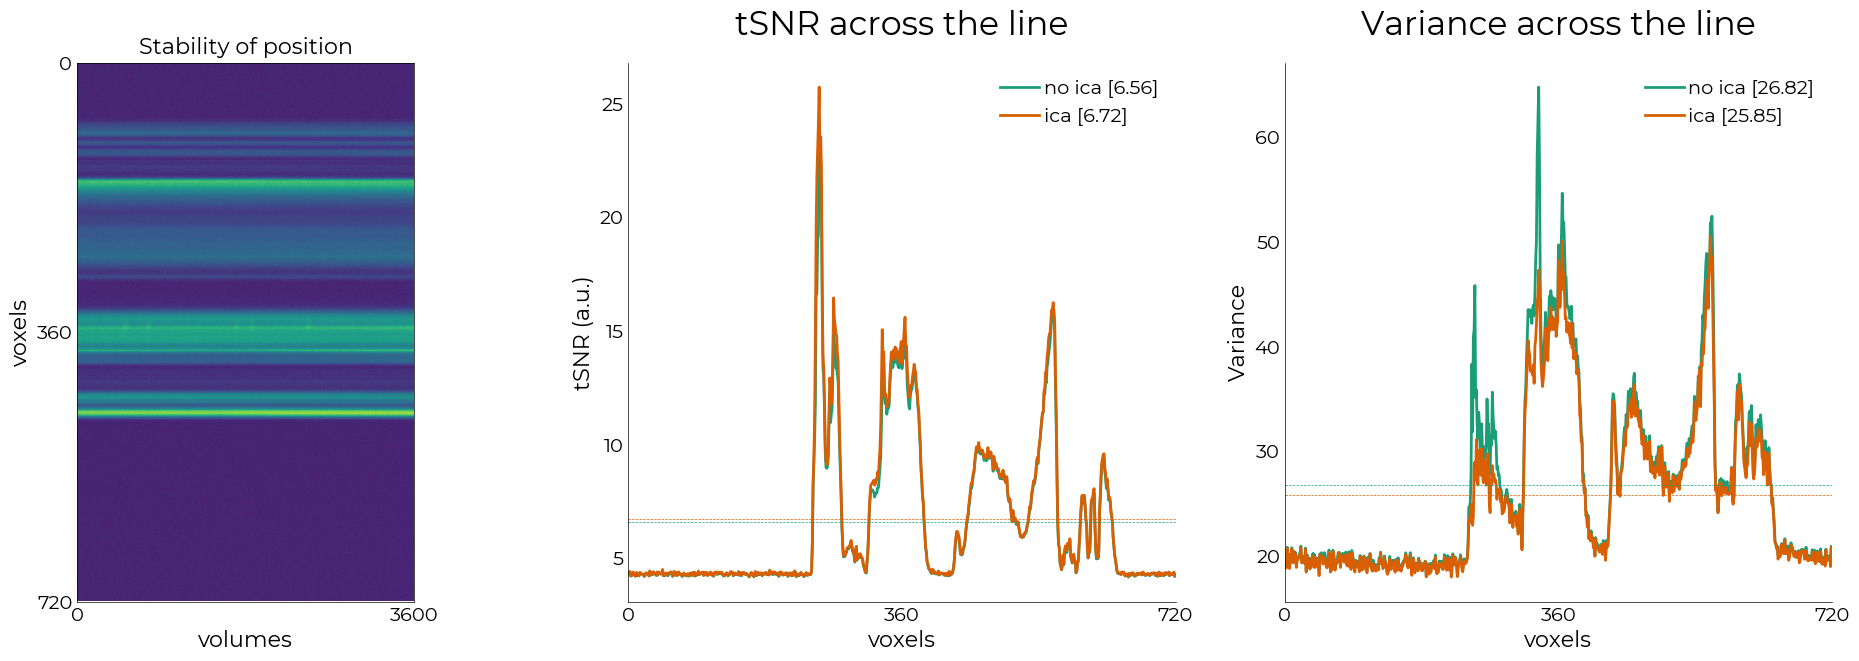

In [9]:
t.basic_qa(
    t.ts_corrected,
    run=1,
    make_figure=True
)

In [5]:
# preprocessed functional data (high-pass + ICA [5 comps])
t.fetch_fmri().head()

Fetching dataframe from attribute 'df_func_ica'


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
01      1   0.000  24.120995  26.884209  -6.523682 -13.212769 -26.410545   
            0.105  60.904526  -4.066521  -5.549294  10.578300 -31.444519   
            0.210 -10.842651 -29.055435  15.535721 -36.002487  15.479706   
            0.315 -22.451355  -3.198715   1.316246 -10.250626 -12.907539   
            0.420  -4.934433   1.994720  50.188454  29.976830   4.476120   

                       vox 5      vox 6      vox 7      vox 8      vox 9  ...  \
subject run t                                                             ...   
01      1   0.000   5.315056  38.903366  -3.039352  32.551918  -0.393814  ...   
            0.105 -13.776810   9.944603 -11.358452  31.305672   7.784973  ...   
            0.210  -7.587608  -1.707916  12.058678 -16.157364  -7.403816  ...   
            0.315 -26.392105   7.321220  50.494293   0.506996  22.063896  ...   
            0.420   9.072395  -2.892616  23.413200 -50.936028  16.053589  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
01      1   0.000  35.238266  68.940781 -46.369793 -12.008331   2.939903   
            0.105  29.101364  -1.237228  42.155609   2.658195  33.851700   
            0.210 -18.747185 -31.623734  -4.397873  79.508301  29.455460   
            0.315 -14.635651  -3.495102   5.431549 -13.444511 -14.753075   
            0.420  19.833023   1.415771   4.240707  38.267975  15.010330   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
01      1   0.000  41.984894  14.404648  10.435143  17.629280 -18.974892  
            0.105 -17.355743  15.824417  20.952255  28.794029  20.434402  
            0.210 -18.974419  -1.437416  45.921638 -24.293549   8.289619  
            0.315  -8.381844 -13.837997  27.244171  -5.284363 -31.195488  
            0.420  12.893593  -4.238487  62.481636 -34.293571  -0.052536  

[5 rows x 720 columns]

In [6]:
# event onsets
t.df_onsets.head()

onset
subject run event_type            
01      1   suppr_1      30.016442
            act          48.358001
            act          74.357842
            suppr_1      96.282811
            suppr_1     113.007627

In [7]:
# preprocessed eyetracking data (in eyetracking sampling time)
t.df_space_eye.head()

AttributeError: 'Dataset' object has no attribute 'df_space_eye'

## `lazyplot.fitting.NideconvFitter`: deconvolve data

You can either input your entire dataset in the fitter, or select a subset of the dataframe using `utils.select_from_df()` based on the columns (used `indices=[354,360]`) or rows/index (`expression="index = value"`):

In [5]:
# select particular run
func = utils.select_from_df(
    t.fetch_fmri(),
    expression="run = 1"
)
func.head()

Fetching dataframe from attribute 'df_func_ica'


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
01      1   0.000  24.121010  26.884201  -6.523689 -13.212769 -26.410530   
            0.105  60.904510  -4.066505  -5.549294  10.578300 -31.444527   
            0.210 -10.842651 -29.055428  15.535721 -36.002487  15.479691   
            0.315 -22.451355  -3.198708   1.316246 -10.250626 -12.907539   
            0.420  -4.934433   1.994728  50.188454  29.976830   4.476120   

                       vox 5      vox 6      vox 7      vox 8      vox 9  ...  \
subject run t                                                             ...   
01      1   0.000   5.315056  38.903381  -3.039375  32.551903  -0.393814  ...   
            0.105 -13.776810   9.944603 -11.358452  31.305672   7.784973  ...   
            0.210  -7.587608  -1.707916  12.058678 -16.157364  -7.403816  ...   
            0.315 -26.392105   7.321220  50.494293   0.506996  22.063896  ...   
            0.420   9.072395  -2.892616  23.413208 -50.936028  16.053589  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
01      1   0.000  35.238266  68.940781 -46.369797 -12.008324   2.939896   
            0.105  29.101364  -1.237221  42.155609   2.658188  33.851700   
            0.210 -18.747185 -31.623734  -4.397865  79.508301  29.455467   
            0.315 -14.635651  -3.495102   5.431549 -13.444511 -14.753075   
            0.420  19.833023   1.415779   4.240707  38.267975  15.010330   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
01      1   0.000  41.984894  14.404663  10.435158  17.629272 -18.974892  
            0.105 -17.355751  15.824417  20.952255  28.794044  20.434395  
            0.210 -18.974419  -1.437416  45.921638 -24.293549   8.289619  
            0.315  -8.381844 -13.837997  27.244179  -5.284363 -31.195488  
            0.420  12.893593  -4.238495  62.481636 -34.293571  -0.052536  

[5 rows x 720 columns]

In [6]:
t.fetch_fmri()

Fetching dataframe from attribute 'df_func_ica'


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                                
01      1   0.000    24.121010  26.884201  -6.523689 -13.212769 -26.410530   
            0.105    60.904510  -4.066505  -5.549294  10.578300 -31.444527   
            0.210   -10.842651 -29.055428  15.535721 -36.002487  15.479691   
            0.315   -22.451355  -3.198708   1.316246 -10.250626 -12.907539   
            0.420    -4.934433   1.994728  50.188454  29.976830   4.476120   
...                        ...        ...        ...        ...        ...   
            377.475 -12.011627 -27.804131  -4.247818   3.850395  13.434715   
            377.580   0.978722  12.072548   1.603676  16.085312  -8.246429   
            377.685 -35.623386   9.984329  51.675240   1.970345  40.135162   
            377.790  37.096939 -13.449570  17.217300 -12.686440  11.852058   
            377.895 -14.316536  14.075386  20.446785  -9.932777  25.556374   

                         vox 5      vox 6      vox 7      vox 8      vox 9  \
subject run t                                                                
01      1   0.000     5.315056  38.903381  -3.039375  32.551903  -0.393814   
            0.105   -13.776810   9.944603 -11.358452  31.305672   7.784973   
            0.210    -7.587608  -1.707916  12.058678 -16.157364  -7.403816   
            0.315   -26.392105   7.321220  50.494293   0.506996  22.063896   
            0.420     9.072395  -2.892616  23.413208 -50.936028  16.053589   
...                        ...        ...        ...        ...        ...   
            377.475 -13.325851 -11.991318  48.694626 -14.418465  17.417793   
            377.580  -9.025551 -13.306900  13.437149  21.946541  -9.839020   
            377.685 -20.763428   8.739861 -10.021584  34.045082   0.650864   
            377.790  16.513260   3.448265  21.950752  23.538857  -1.577194   
            377.895   5.452980  20.317551  32.211617   5.674583   7.165482   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
01      1   0.000    ...  35.238266  68.940781 -46.369797 -12.008324   
            0.105    ...  29.101364  -1.237221  42.155609   2.658188   
            0.210    ... -18.747185 -31.623734  -4.397865  79.508301   
            0.315    ... -14.635651  -3.495102   5.431549 -13.444511   
            0.420    ...  19.833023   1.415779   4.240707  38.267975   
...                  ...        ...        ...        ...        ...   
            377.475  ...  11.003410   5.086433   9.591133   2.009270   
            377.580  ... -13.095047 -42.527115  32.514877 -12.019234   
            377.685  ... -23.774216 -25.980812 -27.767540 -10.051491   
            377.790  ... -10.944649  12.543327  -3.919037   3.668861   
            377.895  ...   2.156181  24.890739 -15.975510  27.382568   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
01      1   0.000     2.939896  41.984894  14.404663  10.435158  17.629272   
            0.105    33.851700 -17.355751  15.824417  20.952255  28.794044   
            0.210    29.455467 -18.974419  -1.437416  45.921638 -24.293549   
            0.315   -14.753075  -8.381844 -13.837997  27.244179  -5.284363   
            0.420    15.010330  12.893593  -4.238495  62.481636 -34.293571   
...                        ...        ...        ...        ...        ...   
            377.475  -1.192749 -31.425163  19.871819   9.320839 -31.430031   
            377.580  20.575027  23.909904 -13.735153 -39.035683 -10.055534   
            377.685  39.635025  14.152061  16.660095  34.088905  18.116859   
            377.790   4.819633   9.076393  15.658363 -12.369011 -27.114166   
            377.895 -13.209038  -3.198730 -20.116196 -11.395653  21.581970   

                       vox 719  
subject ru

In [7]:
# select columns
func = utils.select_from_df(
    t.fetch_fmri(),
    indices=(358,363)
)
func.head()

Fetching dataframe from attribute 'df_func_ica'


vox 358   vox 359   vox 360   vox 361   vox 362
subject run t                                                       
01      1   0.000 -13.839157 -0.588188 -8.102211 -2.139946  4.546150
            0.105 -15.945457 -1.409004  9.016464 -4.400337 -0.167252
            0.210   3.386215 -2.018135 -1.606422  3.617538 -4.278763
            0.315   4.105896 -4.456375 -5.251724  7.006035  1.271133
            0.420  16.345734 -4.209183 -5.079575  0.242401 -9.488388

In [8]:
# initialize the fitter
dec = fitting.NideconvFitter(
    func,
    t.fetch_onsets(),
    basis_sets="canonical_hrf_with_time_derivative",
    TR=0.105,
    interval=[-2,16],
    verbose=True,
    conf_intercept=False
)

dec.timecourses_condition()

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Fitting completed
Fetching subject/condition-wise time courses from <nideconv.group_analysis.GroupResponseFitter object at 0x12cc8bf50>


In [103]:
# average over the voxels and parse into list
evs = utils.get_unique_ids(dec.tc_condition, id="event_type")

tc,se,pr = [],[],[]
for i in evs:
    avg = utils.select_from_df(
        dec.tc_condition,
        expression=f"event_type = {i}"
    )

    pred = utils.select_from_df(
        dec.ev_predictions,
        expression=f"event_type = {i}"
    )

    tc.append(avg.mean(axis=1).values)
    se.append(avg.sem(axis=1).values)
    pr.append(pred.mean(axis=1).values)

## `lazyplot.plotting.LazyLine`: plot simple lines

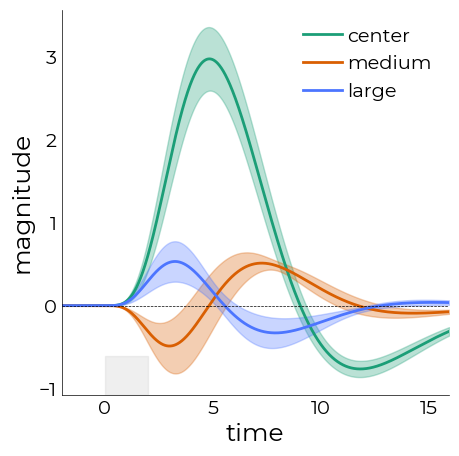

In [10]:
%matplotlib inline

# do some plotting
pl = plotting.LazyLine(
    tc,
    xx=dec.time,
    figsize=(5,5),
    color=["#1B9E77","#D95F02","#4c75ff"],
    error=se,
    line_width=2,
    labels=["center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0
)

plotting.add_axvspan(
    pl.axs, 
    ymax=0.1
)

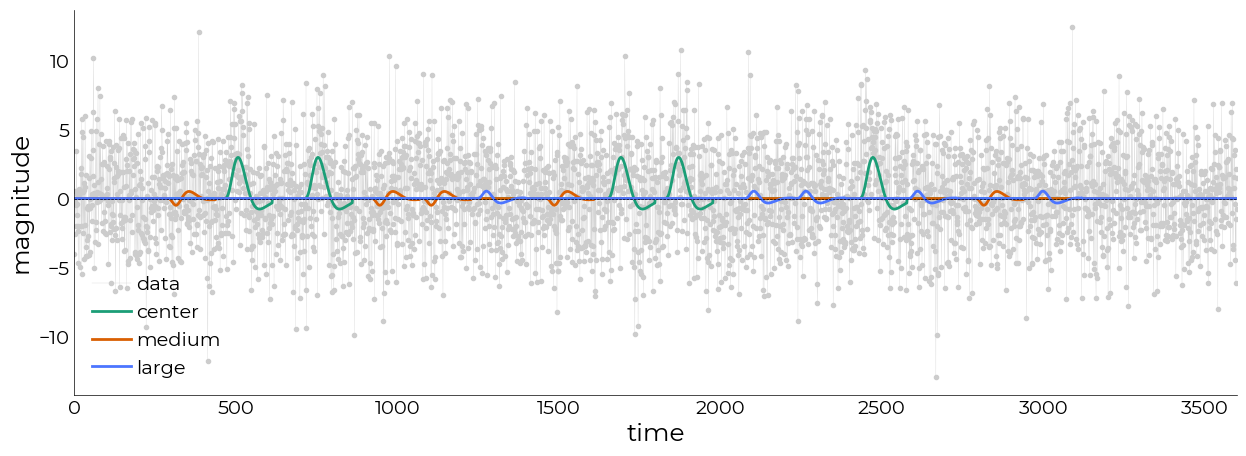

In [11]:
%matplotlib inline

# do some plotting
pl = plotting.LazyLine(
    [dec.func.mean(axis=1).values]+pr,
    figsize=(15,5),
    color=["#cccccc","#1B9E77","#D95F02","#4c75ff"],
    line_width=[0.2,2,2,2],
    labels=["data","center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0,
    markers=[".", None, None, None]
)

## `lazyplot.preproc.DataFilter`: apply filter to entire dataframe

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Fitting completed
Fetching subject/condition-wise time courses from <nideconv.group_analysis.GroupResponseFitter object at 0x13a324b50>


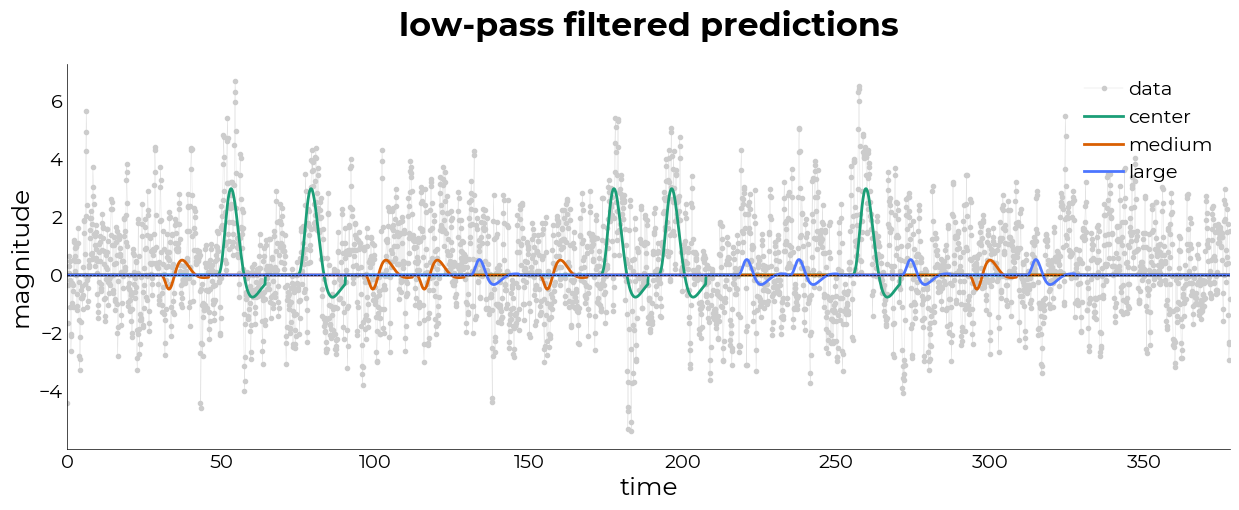

In [104]:
%matplotlib inline

filt = preproc.DataFilter(
    dec.func,
    filter_strategy="lp"
)

# initialize the fitter
dec = fitting.NideconvFitter(
    filt.df_filt,
    t.fetch_onsets(),
    basis_sets="canonical_hrf_with_time_derivative",
    TR=0.105,
    interval=[-2,16],
    verbose=True,
    conf_intercept=False
)

dec.timecourses_condition()

# average over the voxels and parse into list
evs = utils.get_unique_ids(dec.tc_condition, id="event_type")

tc,se,pr = [],[],[]
for i in evs:
    avg = utils.select_from_df(
        dec.tc_condition,
        expression=f"event_type = {i}"
    )

    pred = utils.select_from_df(
        dec.ev_predictions,
        expression=f"event_type = {i}"
    )

    tc.append(avg.mean(axis=1).values)
    se.append(avg.sem(axis=1).values)
    pr.append(pred.mean(axis=1).values)


# do some plotting
pl = plotting.LazyLine(
    [dec.func.mean(axis=1).values]+pr,
    xx=utils.get_unique_ids(dec.func, id="t"),
    figsize=(15,5),
    color=["#cccccc","#1B9E77","#D95F02","#4c75ff"],
    line_width=[0.2,2,2,2],
    labels=["data","center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0,
    markers=[".", None, None, None],
    title={
        "title": "low-pass filtered predictions",
        "fontweight": "bold"
    }
)


These classes also have the capability to extract relevant information from the deconvolved HRF profiles. The success of the estimation depends on the basis sets used and the quality of the data.

In [109]:
dec.parameters_for_tc_subjects()
dec.pars_subjects.head()

Deriving parameters from <lazyplot.fitting.NideconvFitter object at 0x13a1bf190> with 'HRFMetrics'


magnitude  magnitude_ix      fwhm  \
subject event_type run vox                                          
01      act        1   vox 358   2.468517          1485  4.364607   
                       vox 359   2.800197          1206  4.146082   
                       vox 360   2.781313          1197  4.108455   
                       vox 361   2.951905          1328  4.450904   
                       vox 362   4.425694          1316  4.437914   

                                                                     fwhm_obj  \
subject event_type run vox                                                      
01      act        1   vox 358  <lazyplot.fitting.FWHM object at 0x13a4fde50>   
                       vox 359  <lazyplot.fitting.FWHM object at 0x13a638250>   
                       vox 360  <lazyplot.fitting.FWHM object at 0x12f010050>   
                       vox 361  <lazyplot.fitting.FWHM object at 0x13a337850>   
                       vox 362  <lazyplot.fitting.FWHM object at 0x13a4eb210>   

                                time_to_peak  half_rise_time  half_max  \
subject event_type run vox                                               
01      act        1   vox 358      5.798530        3.806110  1.234258   
                       vox 359      4.333352        2.446870  1.400099   
                       vox 360      4.286088        2.420088  1.390656   
                       vox 361      4.974039        2.910220  1.475953   
                       vox 362      4.911021        2.854645  2.212847   

                                rise_slope  onset_time  positive_area  \
subject event_type run vox                                              
01      act        1   vox 358    1.005996    2.585878      10.662559   
                       vox 359    1.182179    1.263885      11.574577   
                       vox 360    1.186380    1.249288      11.392863   
                       vox 361    1.110886    1.580245      13.116424   
                       vox 362    1.677046    1.534246      19.601909   

                                undershoot  1st_deriv_magnitude  \
subject event_type run vox                                        
01      act        1   vox 358    2.816166            -0.116012   
                       vox 359    3.700150             1.241322   
                       vox 360    3.689621             1.246188   
                       vox 361    3.738860             1.167257   
                       vox 362    5.631915             1.761870   

                                1st_deriv_time_to_peak  2nd_deriv_magnitude  \
subject event_type run vox                                                    
01      act        1   vox 358                1.192934            -0.174462   
                       vox 359                2.421793             0.918909   
                       vox 360                2.395535             0.932690   
                       vox 361                2.920689             0.735636   
                       vox 362                2.857670             1.124998   

                                2nd_deriv_time_to_peak  
subject event_type run vox                              
01      act        1   vox 358                0.741302  
                       vox 359                1.313719  
                       vox 360                1.297964  
                       vox 361                1.670823  
                       vox 362                1.618308

## `lazyplot.plotting.LazyBar`: barplots including significance bars


                   W      pval  normal
magnitude  0.961831  0.724178    True

        Source  ddof1  ddof2          F     p-unc      np2
0  event_type      2     12  17.535834  0.000274  0.74507

      Contrast        A        B  Paired  Parametric         T  dof  \
1  event_type      act  suppr_2    True        True  5.036346  4.0   
0  event_type      act  suppr_1    True        True  6.173944  4.0   
2  event_type  suppr_1  suppr_2    True        True -0.784411  4.0   

  alternative     p-unc    p-corr p-adjust   BF10     cohen  distances  
1   two-sided  0.007301  0.014602     holm  8.849  3.556339          2  
0   two-sided  0.003496  0.010487     holm   15.1  3.202325          1  
2   two-sided  0.476648  0.476648     holm  0.505 -0.438658          1  


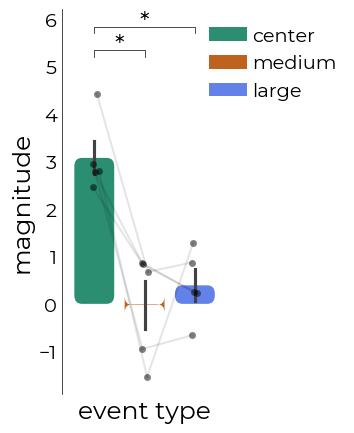

In [19]:
# which we can then flop into a LazyBar-object
br = plotting.LazyBar(
    dec.pars_subjects,
    figsize=(2,5),
    x="event_type",
    y="magnitude",
    sns_offset=4,
    fancy=True,
    x_label="event type",
    y_label="magnitude",
    connect=True,
    points_color="k",
    points_alpha=0.5,
    palette=["#1B9E77","#D95F02","#4c75ff"],
    lbl_legend=["center","medium","large"],
    bar_legend=True,
    bbox_to_anchor=(0.8,1)
)

# add the stats
normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "vox",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=0,
    y_pos=1.15,
    line_separate_factor=-0.075
)

print("\n", normality)
print("\n", aov.ano)
print("\n", aov.posthoc_sorted)

## `lazyplot.plotting.LazyHist`: plot histograms

In [111]:
glms = pd.read_csv(opj(data_dir,"glms.csv"), usecols=lambda column: not column.startswith("Unnamed"))

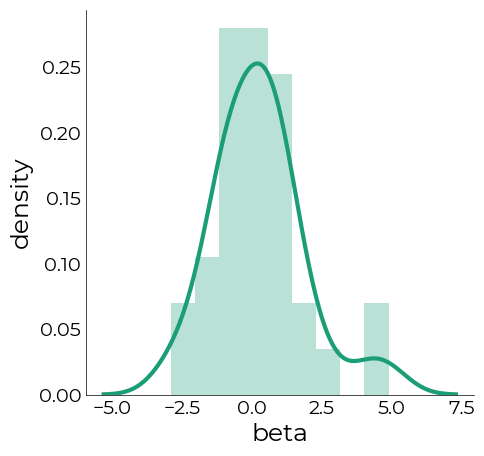

In [112]:
color = "#1B9E77"
hist = plotting.LazyHist(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    )["beta"],
    figsize=(5,5),
    kde=True,
    color=color,
    kde_kwargs={
        "linewidth": 3,
    },
    hist_kwargs={
        "alpha": 0.3,
        "fc": color
    },
    x_label="beta",
    y_label="density"
)

## `lazyplot.fitting.ParameterFitter`: estimate parameters from double-gamma HRF

The double-gamma HRF can also be described by a set of parameters (7), rather than a set of basissets that is used for deconvolution. Similar to pRF fitting, this becomes an optimization procedure. This class iteratively assesses the best combination of parameters that mimimizes the error between the prediction the HRF generates and the actual data.

In [ ]:
par = fitting.ParameterFitter(
    filt.df_filt,
    t.fetch_onsets()
)

par.fit(
    osf=1, # higher values slow down the convolution process, but are more accurate wrt the onsets
    verbose=True, 
    n_jobs=None # "None" sets the number of jobs to the number of input voxels.. be careful with a large number of voxels. Use an integer value to constrain the process to a certain number of jobs.
)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   24.7s remaining:   37.1s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   49.8s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   21.9s remaining:   32.9s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   45.0s finished
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:   20.6s remaining:   30.8s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:   35.8s finished


In [98]:
# from this, we can extract estimates of individual parameter estimates that generate the full HRF
par.estimates.head()

a1         a2        b1        b2  \
subject event_type run vox                                                
01      act        1   vox 358  7.999986  10.000003  1.158610  0.800000   
                       vox 359  4.911836  10.564334  1.076591  0.800003   
                       vox 360  4.176546  11.129979  1.199997  0.800005   
                       vox 361  4.000091  13.686921  1.199999  0.800004   
                       vox 362  6.042051  12.164910  0.869612  0.800002   

                                       c        d1         d2  
subject event_type run vox                                     
01      act        1   vox 358  0.488982  4.907072  14.959780  
                       vox 359  0.402760  9.999969  13.874413  
                       vox 360  0.365645  9.651971  14.378838  
                       vox 361  0.416347  2.082332  13.708682  
                       vox 362  0.445467  9.999975  14.638781

In [99]:
# similar to deconvolution, we can call this function to extract relevant parameters from the HRF generated with the estimates
par.parameters_for_tc_subjects()
par.pars_subjects.head()

magnitude  magnitude_ix      fwhm  \
subject event_type run vox                                          
01      act        1   vox 358   2.350515             7  4.289343   
                       vox 359   2.842579             5  4.125753   
                       vox 360   2.753171             4  4.265000   
                       vox 361   2.870323             5  5.245565   
                       vox 362   4.602402             5  4.329915   

                                                                     fwhm_obj  \
subject event_type run vox                                                      
01      act        1   vox 358  <lazyplot.fitting.FWHM object at 0x138ac9850>   
                       vox 359  <lazyplot.fitting.FWHM object at 0x13802b690>   
                       vox 360  <lazyplot.fitting.FWHM object at 0x138019350>   
                       vox 361  <lazyplot.fitting.FWHM object at 0x137febdd0>   
                       vox 362  <lazyplot.fitting.FWHM object at 0x139e6cb50>   

                                time_to_peak  half_rise_time  half_max  \
subject event_type run vox                                               
01      act        1   vox 358      7.241379        5.075891  1.171200   
                       vox 359      5.172414        2.697976  1.421168   
                       vox 360      4.137931        2.507538  1.375451   
                       vox 361      5.172414        2.483631  1.434844   
                       vox 362      5.172414        3.065600  2.298418   

                                rise_slope  onset_time  positive_area  \
subject event_type run vox                                              
01      act        1   vox 358    0.753576    3.521701       9.092618   
                       vox 359         NaN         NaN      11.232870   
                       vox 360         NaN         NaN      11.225525   
                       vox 361         NaN         NaN      14.913531   
                       vox 362    1.633259    1.658337      19.311170   

                                undershoot  1st_deriv_magnitude  \
subject event_type run vox                                        
01      act        1   vox 358    5.176764             0.761063   
                       vox 359    2.977184             1.029912   
                       vox 360    3.470401             0.925612   
                       vox 361    1.665688             0.947662   
                       vox 362    3.876998             1.631864   

                                1st_deriv_time_to_peak  2nd_deriv_magnitude  \
subject event_type run vox                                                    
01      act        1   vox 358                5.172414             0.259572   
                       vox 359                3.103448             0.400542   
                       vox 360                2.068966             0.392741   
                       vox 361                2.068966             0.389894   
                       vox 362                3.103448             0.632060   

                                2nd_deriv_time_to_peak  
subject event_type run vox                              
01      act        1   vox 358                4.137931  
                       vox 359                1.034483  
                       vox 360                1.034483  
                       vox 361                1.034483  
                       vox 362                2.068966

In [105]:
# the output from the parameter fitter is the same as those from deconvolution using nideconv, so we can use the same code to generate plots
evs = utils.get_unique_ids(par.tc_condition, id="event_type")

tc1,se1,pr1 = [],[],[]
for i in evs:
    avg = utils.select_from_df(
        par.tc_condition,
        expression=f"event_type = {i}"
    )

    pred = utils.select_from_df(
        par.ev_predictions,
        expression=f"event_type = {i}"
    )

    tc1.append(avg.mean(axis=1).values)
    se1.append(avg.sem(axis=1).values)
    pr1.append(pred.mean(axis=1).values)

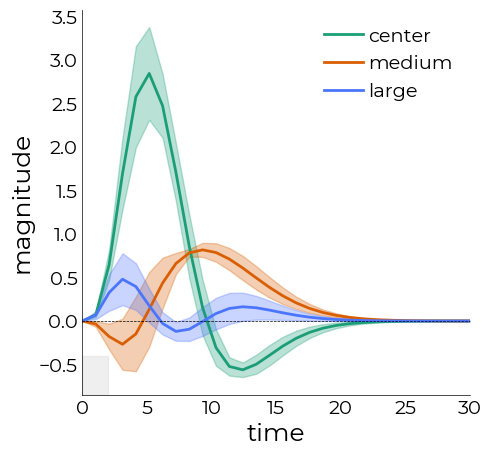

In [107]:
%matplotlib inline

# do some plotting
pl = plotting.LazyLine(
    tc1,
    xx=utils.get_unique_ids(par.tc_condition, id="time"),
    figsize=(5,5),
    color=["#1B9E77","#D95F02","#4c75ff"],
    error=se1,
    line_width=2,
    labels=["center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0
)

plotting.add_axvspan(
    pl.axs, 
    ymax=0.1
)

## Summary Figure

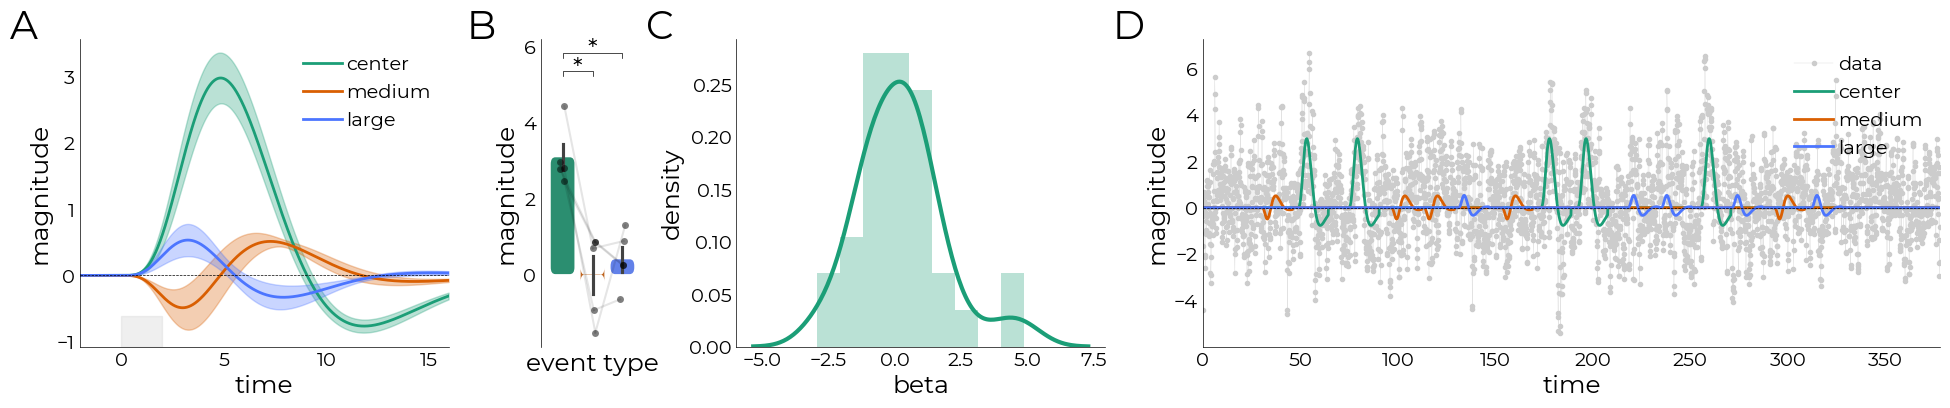

In [113]:
fig,axs = plt.subplots(
    ncols=4,
    width_ratios=[0.2,0.05,0.2,0.4],
    figsize=(24,4),
    gridspec_kw={
        "wspace": 0.25
    }
)

# LazyLine
pl = plotting.LazyLine(
    tc,
    xx=dec.time,
    axs=axs[0],
    color=["#1B9E77","#D95F02","#4c75ff"],
    error=se,
    line_width=2,
    labels=["center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0
)

plotting.add_axvspan(
    pl.axs, 
    ymax=0.1
)

# LazyBar
br = plotting.LazyBar(
    dec.pars_subjects,
    axs=axs[1],
    x="event_type",
    y="magnitude",
    sns_offset=4,
    fancy=True,
    x_label="event type",
    y_label="magnitude",
    connect=True,
    points_color="k",
    points_alpha=0.5,
    palette=["#1B9E77","#D95F02","#4c75ff"],
    lbl_legend=["center","medium","large"],
)

# add the stats
normality = pg.normality(br.data[br.y])
is_normal = normality["normal"][0]

aov = glm.ANOVA(
    data=br.data,
    dv=br.y,
    between=br.x,
    # test="test",
    parametric=is_normal,
    posthoc_kw={
        "effsize": "cohen",
        "test": "test",
        "paired": True,
        "subject": "vox",
        "padjust": "holm"
    }
)

aov.plot_bars( 
    axs=br.ff,
    ast_frac=-0.015,
    y_pos=1.15,
    line_separate_factor=-0.075
)

# LazyHist
plotting.LazyHist(
    utils.multiselect_from_df(
        glms,
        expression=[
            "preproc = corr",
            "method = norm",
            "model = camel_deriv"
        ]
    )["beta"],
    axs=axs[2],
    kde=True,
    color="#1B9E77",
    kde_kwargs={
        "linewidth": 3,
    },
    hist_kwargs={
        "alpha": 0.3,
        "fc": "#1B9E77"
    },
    x_label="beta",
    y_label="density"
)

# Timecourse (predictions)
pl = plotting.LazyLine(
    [dec.func.mean(axis=1).values]+pr,
    xx=utils.get_unique_ids(dec.func, id="t"),
    axs=axs[-1],
    color=["#cccccc","#1B9E77","#D95F02","#4c75ff"],
    line_width=[0.2,2,2,2],
    labels=["data","center","medium","large"],
    x_label="time",
    y_label="magnitude",
    add_hline=0,
    markers=[".", None, None, None],
)

plotting.fig_annot(
    fig,
    x0_corr=-0.7,
    x_corr=[-0.8,-0.9,-0.9],
    y=1
)

# fig.savefig(
#     opj(data_dir, "example.png"),
#     bbox_inches="tight",
#     dpi=300,
#     facecolor="white"
# )